# Template: Fraud Detection with Probability Distributions

#### Fraud Detection System Template
#### Author: Stephen
#### Date: 2025-06-02

#### Step1
we will first import the libraries that we need for this project

✅ What it does:
This step loads all the essential Python libraries used in the notebook, including:

        numpy, pandas: For numerical and data manipulation tasks.

        matplotlib, seaborn: For visualizations.

        scipy.stats: For statistical functions like Z-score and Poisson.

        sklearn: For machine learning and anomaly detection models (e.g., Isolation Forest).

        ConfusionMatrixDisplay: For evaluating model performance.

🎯 Objective:
To prepare the environment with all necessary tools for performing data analysis, modeling, visualization, and evaluation.

🧠 Why it’s important:
Libraries provide pre-built, optimized functions that save time and ensure reliability. Without these, building models and performing statistical tests would be far more time-consuming and error-prone.

In [1]:
# 📦 Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, poisson, multivariate_normal, beta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

we will check the versions of our libraries

#### step2
In step 2 we wii either load our data in the case we have the data or Create Synthetic Data.
In this case we will Create Synthetic Data.

✅ What it does:
This step creates a synthetic dataset that simulates both normal and fraudulent transaction data:

        1000 normal transactions with realistic behavior (moderate amounts, larger time gaps).

        20 fraudulent transactions with distinct patterns (larger amounts, quicker intervals).

        Labels (is_fraud) are added to identify fraud cases.

🎯 Objective:
To provide a controlled dataset for testing fraud detection techniques in the absence of real-world data.

🧠 Why it’s important:
In real-life, fraud datasets are often confidential or imbalanced. Synthetic data allows experimentation, benchmarking, and model validation in a safe and repeatable manner.

In [32]:
# 🧹 Step 2: Load or Create Synthetic Data
np.random.seed(42)

In [33]:
# Simulate normal transaction behavior
n_normal = 1000
amounts = np.random.normal(loc=50, scale=10, size=n_normal)
times = np.random.exponential(scale=30, size=n_normal)

In [34]:
# Add fraud cases
n_fraud = 20
fraud_amounts = np.random.normal(loc=200, scale=30, size=n_fraud)
fraud_times = np.random.exponential(scale=5, size=n_fraud)

In [35]:
# Combine data
amounts_all = np.concatenate([amounts, fraud_amounts])
times_all = np.concatenate([times, fraud_times])
labels = np.array([0]*n_normal + [1]*n_fraud)  # 0 = normal, 1 = fraud

df = pd.DataFrame({
    'amount': amounts_all,
    'time_since_last': times_all,
    'is_fraud': labels
})

print(df.head())

      amount  time_since_last  is_fraud
0  54.967142         5.499034         0
1  48.617357         3.313465         0
2  56.476885        30.353523         0
3  65.230299        36.773848         0
4  47.658466         0.962872         0


##### 🧾 Explanation of the Simulated Fraud Detection Data
The dataset consists of three columns and each row represents a single financial transaction.

    🔹 1. amount
        Description: This column contains the monetary value of each transaction.

        Data Type: Float (e.g., 54.96, 48.61)

        Purpose: Helps detect unusually high (or low) transaction values which could indicate fraudulent behavior.

        Why it matters: Fraudulent transactions often involve abnormally large amounts or show suspicious patterns compared to regular customer behavior.

    🔹 2. time_since_last
        Description: Time elapsed (in arbitrary time units, often minutes or hours) since the previous transaction.

        Data Type: Float (e.g., 5.49, 3.31)

        Purpose: Captures behavioral timing patterns—e.g., whether the user transacts too frequently.

        Why it matters: Fraud often happens in bursts or in rapid succession, unlike normal behavior which is spaced out. A very low value here may be suspicious.

    🔹 3. is_fraud
        Description: Binary label that indicates whether the transaction is fraudulent.

        Values:

            0 = Not fraud (normal transaction)

            1 = Fraudulent transaction

        Purpose: Ground-truth label used to train or evaluate detection models.

        Why it matters: This label allows supervised learning models to learn what fraud looks like, and helps us measure how accurately our anomaly detection methods flag real frauds.

#### Step 3 Anomaly Detection
In this section we will perform Explanatory Data Analysis (EDA) and Data Visualization

✅ What it does:
Applies multiple unsupervised anomaly detection techniques to flag potentially fraudulent transactions:

        Z-score: Flags statistical outliers based on standard deviation.

        Poisson distribution: Flags low-probability events using time-based behavior.

        Mahalanobis distance: Flags points that are multivariate outliers.

        Isolation Forest: A machine learning method that isolates anomalies in high-dimensional space.

Each method produces a binary outlier flag (1 = fraud suspected, 0 = normal).

🎯 Objective:
To detect suspicious patterns without explicitly training on labeled fraud cases, mimicking real-world situations where new fraud types emerge constantly.

🧠 Why it’s important:
Fraudulent behavior is often rare and not always labeled. Anomaly detection allows the system to learn from normal behavior and spot anything that deviates significantly.

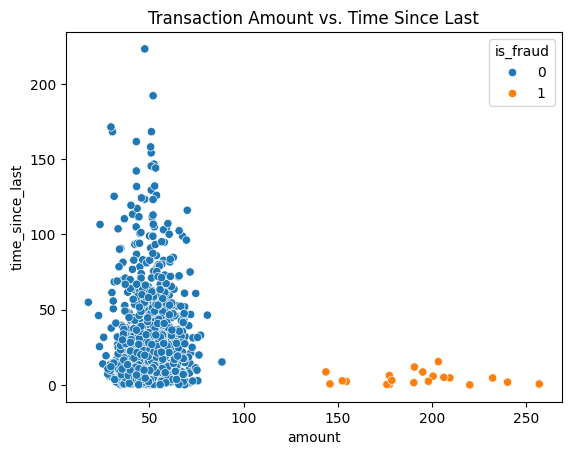

In [36]:
# 🕵️‍♂️ Step 3: EDA and Visualization
sns.scatterplot(data=df, x='amount', y='time_since_last', hue='is_fraud')
plt.title("Transaction Amount vs. Time Since Last")
plt.show()

In [38]:
# 📈 Step 3: Anomaly Detection

# Z-score method
df['z_amount'] = zscore(df['amount'])
df['z_time'] = zscore(df['time_since_last'])
df['z_outlier'] = ((df['z_amount'].abs() > 3) | (df['z_time'].abs() > 3)).astype(int)

# Poisson method
lambda_poisson = df[df['is_fraud'] == 0]['time_since_last'].mean()
df['poisson_prob'] = poisson.pmf(np.round(df['time_since_last']), mu=lambda_poisson)
df['poisson_anomaly'] = (df['poisson_prob'] < 0.01).astype(int)

# Mahalanobis distance
from scipy.spatial import distance

def mahalanobis_dist(row, mean, cov_inv):
    x = np.array([row['amount'], row['time_since_last']])
    return distance.mahalanobis(x, mean, cov_inv)

X = df[['amount', 'time_since_last']]
mean_vec = X.mean().values
cov_mat = np.cov(X.T)
cov_inv = np.linalg.inv(cov_mat)
df['mahalanobis'] = X.apply(mahalanobis_dist, axis=1, args=(mean_vec, cov_inv))
df['mahalanobis_outlier'] = (df['mahalanobis'] > 3.0).astype(int)

# Isolation Forest
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iso = IsolationForest(contamination=0.02, random_state=42)
df['isolation_outlier'] = (iso.fit_predict(X_scaled) == -1).astype(int)

print(df.head())

      amount  time_since_last  is_fraud  z_amount    z_time  z_outlier  \
0  54.967142         5.499034         0  0.088580 -0.807772          0   
1  48.617357         3.313465         0 -0.195092 -0.880625          0   
2  56.476885        30.353523         0  0.156026  0.020727          0   
3  65.230299        36.773848         0  0.547078  0.234741          0   
4  47.658466         0.962872         0 -0.237930 -0.958980          0   

   poisson_prob  poisson_anomaly  mahalanobis  mahalanobis_outlier  \
0  1.551728e-08                1     0.807375                    0   
1  3.393861e-10                1     0.927718                    0   
2  7.256544e-02                0     0.160517                    0   
3  3.233576e-02                0     0.621914                    0   
4  2.226865e-12                1     1.018647                    0   

   isolation_outlier  
0                  0  
1                  0  
2                  0  
3                  0  
4                  

#### Step 4: Evaluation Metrics
✅ What it does:
For each detection method, the notebook calculates:

        Confusion Matrix: Shows the count of true positives, false positives, etc.

        Precision: Measures how many flagged frauds were actually fraud.

        Recall: Measures how many actual frauds were successfully flagged.

Visualizations are provided for better understanding.

🎯 Objective:
To quantitatively assess the performance of each fraud detection technique.

🧠 Why it’s important:
Fraud detection systems must be both accurate and cautious. These metrics help decide which method strikes the best balance between catching fraud and avoiding false alarms.


--- Z_OUTLIER ---


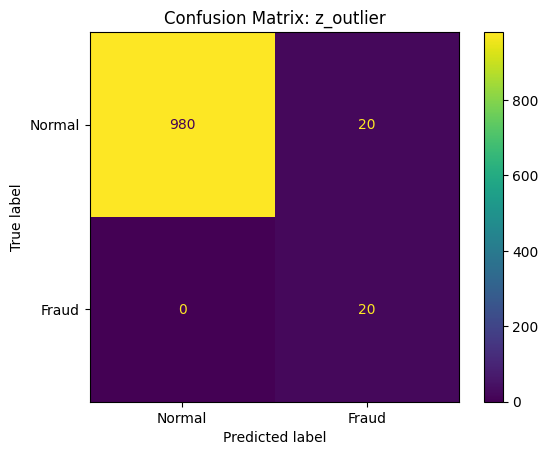

Precision: 0.50, Recall: 1.00

--- POISSON_ANOMALY ---


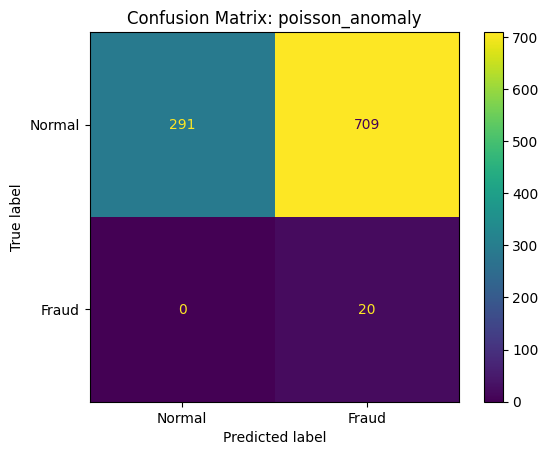

Precision: 0.03, Recall: 1.00

--- MAHALANOBIS_OUTLIER ---


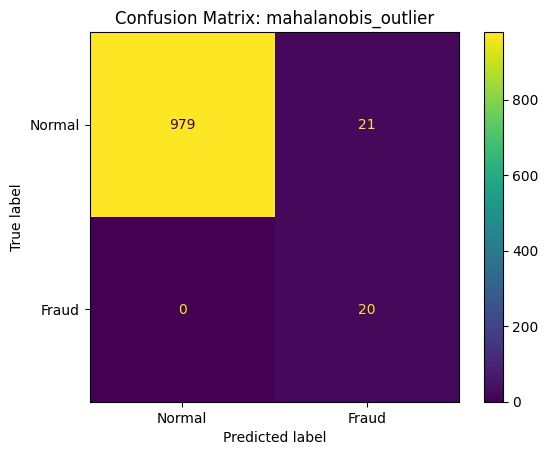

Precision: 0.49, Recall: 1.00

--- ISOLATION_OUTLIER ---


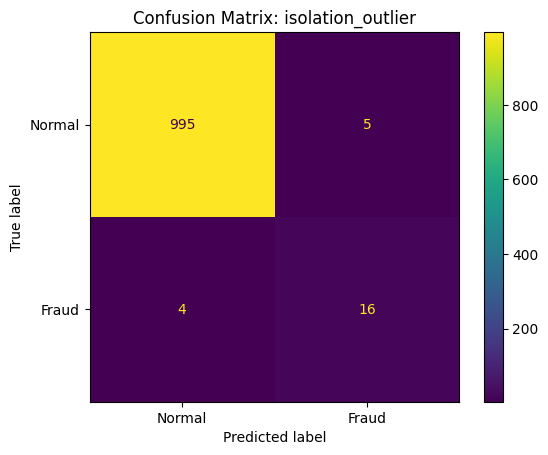

Precision: 0.76, Recall: 0.80


In [25]:
# 🧮 Step 4: Evaluation Metrics
methods = ['z_outlier', 'poisson_anomaly', 'mahalanobis_outlier', 'isolation_outlier']

for method in methods:
    print(f"\n--- {method.upper()} ---")
    cm = confusion_matrix(df['is_fraud'], df[method])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
    disp.plot()
    plt.title(f"Confusion Matrix: {method}")
    plt.show()
    precision = precision_score(df['is_fraud'], df[method])
    recall = recall_score(df['is_fraud'], df[method])
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

#### Step 5: Bayesian Updating of Fraud Probability
✅ What it does:
Uses Bayesian inference to update beliefs about the fraud rate in the population based on detected anomalies:

        Starts with a prior belief (e.g., 2 out of 100 transactions are fraudulent).

        Updates to a posterior distribution using observed fraud counts.

        Plots the updated probability of fraud.

🎯 Objective:
To quantify uncertainty and continuously refine fraud probability estimates based on new data.

🧠 Why it’s important:
Bayesian updating introduces adaptive learning to the system. It accounts for prior knowledge while also reacting to new evidence, ideal for dynamic fraud environments.

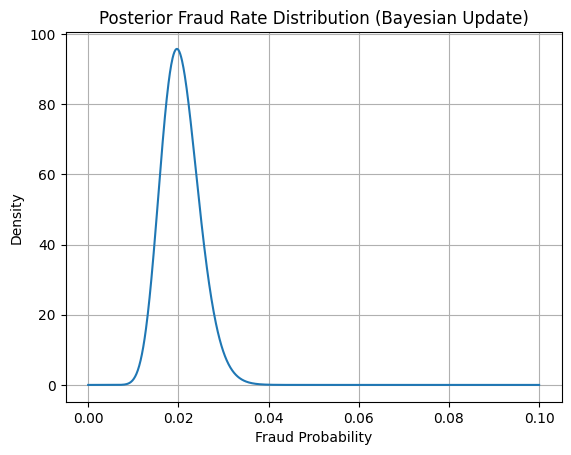

In [39]:
# 📊 Step 5: Bayesian Updating of Fraud Probability
# Use Beta distribution as prior for fraud rate (e.g., assume prior 2 frauds in 100 transactions)

alpha_prior = 2
beta_prior = 98

fraud_detected = df['isolation_outlier'].sum()
non_fraud_detected = len(df) - fraud_detected

alpha_post = alpha_prior + fraud_detected
beta_post = beta_prior + non_fraud_detected

x = np.linspace(0, 0.1, 1000)
posterior = beta.pdf(x, alpha_post, beta_post)

plt.plot(x, posterior)
plt.title("Posterior Fraud Rate Distribution (Bayesian Update)")
plt.xlabel("Fraud Probability")
plt.ylabel("Density")
plt.grid(True)
plt.show()

#### Step 6: Streamlit Dashboard Hint
✅ What it does:
Provides example code and guidance to deploy the fraud detection logic as a live dashboard using Streamlit, a Python web app framework.

The dashboard would allow users to:

        Upload transaction data.

        Run detection models in real-time.

        Visualize fraud patterns, precision/recall scores, and posterior fraud rates.

🎯 Objective:
To enable real-time monitoring and user-friendly interaction with the fraud detection system.

🧠 Why it’s important:
In real-world applications, fraud detection systems must be integrated with operational tools. Dashboards make insights accessible to analysts and decision-makers instantly.

In [30]:
# 📲 Step 6: Streamlit Dashboard Hint (Run in a .py with `streamlit run app.py`)
# fraud_dashboard.py
import streamlit as st

st.title("Fraud Detection Dashboard")

st.write("## Sample Transactions")
st.dataframe(df[['amount', 'time_since_last', 'z_outlier', 'isolation_outlier', 'is_fraud']].head(20))

st.write("## Fraud Probability Estimate (Bayesian)")
st.line_chart(posterior)

2025-06-02 12:26:55.820 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.199 
  command:

    streamlit run c:\Users\STEVE\OneDrive\Desktop\PYTHON\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-02 12:26:58.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.453 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 12:26:58.457 Thr

DeltaGenerator()

### 🔍 What This Notebook Covers:
Generates synthetic fraud and normal data.

Applies:

    Z-score (normal distribution assumption)

    Poisson anomaly detection (event timing)

    Mahalanobis distance (multivariate normal)

    Isolation Forest (ML-based anomaly detection)

    Flags potential fraud using statistical thresholds.

    Visualizes and compares detection methods.